<ipython-input-1-973c4ca02ac0>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  fake_df.columns = ((fake_df.columns.str).replace("^ ","")).str.replace(" $","")
<ipython-input-1-973c4ca02ac0>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  fake_df.columns = ((fake_df.columns.str).replace("^ ","")).str.replace(" $","")
<ipython-input-1-973c4ca02ac0>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  real_df.columns = ((real_df.columns.str).replace("^ ","")).str.replace(" $","")
<ipython-input-1-973c4ca02ac0>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  real_df.columns = ((real_df.columns.str).replace("^ ","")).str.replace(" $","")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 500)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 500, 128)          2560128   
                                                                 
 conv1d (Conv1D)             (None, 165, 128)          114816    
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 128)           114816    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                             

<Axes: >

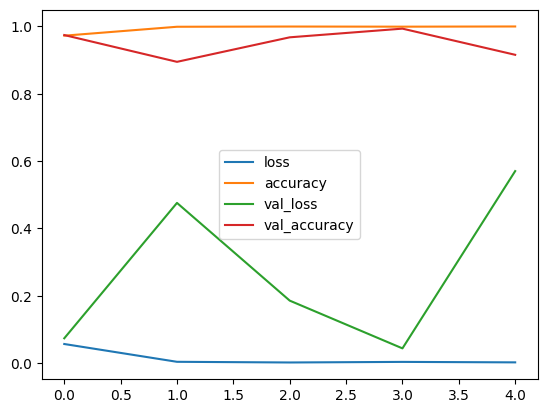

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

fake_df = pd.read_csv('/content/drive/MyDrive/Fake.csv')
real_df = pd.read_csv('/content/drive/MyDrive/True.csv')

with open ('/content/drive/MyDrive/Fake.csv', "r") as file:
        fake_df = pd.read_csv(file, delimiter = ",")
        fake_df.columns = ((fake_df.columns.str).replace("^ ","")).str.replace(" $","")

with open ('/content/drive/MyDrive/True.csv', "r") as file:
        real_df = pd.read_csv(file, delimiter = ",")
        real_df.columns = ((real_df.columns.str).replace("^ ","")).str.replace(" $","")

#classification
real_df['isFake'] = 0
fake_df['isFake'] = 1

data = pd.concat([real_df,fake_df])

data['text'] = data['title'] + data['text'] + data['subject']
data['text'] = data['text'].astype('str')
data = data.drop('title',axis=1)
data = data.drop('subject',axis=1)

features = 20000 # Maximum vocab size.
seq_len = 500 # Sequence length to pad the outputs to.

# Create the layer
vectorization_layer = layers.TextVectorization(
    max_tokens=features,
    output_mode='int',
    output_sequence_length=seq_len,
    standardize='lower_and_strip_punctuation')

# Now that the vocab layer has been created, calling `adapt` on the
# text-only dataset is necessry to create the vocabulary.
vectorization_layer.adapt(data['text'].values)

#vocabulary creation: Vocabulary is the set of unique words in the training dataset
txt_input = tf.keras.Input(shape=(1,), dtype=tf.string)
x = vectorization_layer(txt_input)
x = layers.Embedding(features+1,128)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)

# Create the model that uses the output from the vectorize text layer
model = tf.keras.Model(txt_input, output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# fit model
history = model.fit(
    x=data['text'].values,
    y=data['isFake'].values,
    epochs=5,
    validation_split=0.3,
    shuffle=True,
    callbacks=[callback])


pd.DataFrame(history.history).plot()

421/421 [==============================] - 19s 44ms/step


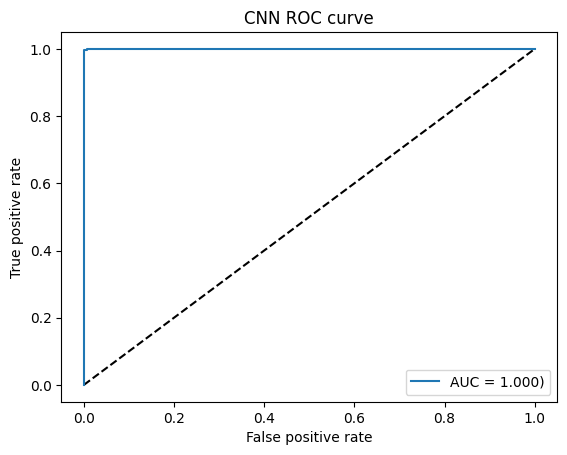

In [ ]:
# We can identify overfitting by looking at validation metrics, like loss or accuracy.
# Usually, the validation metric stops improving after a certain number of epochs and begins to decrease afterward.
# The training metric continues to improve because the model seeks to find the best fit for the training data.

#Generally, a model is underfitting the training data when the model performs poorly on the training data tahn the test data.
#This is because the model is unable to capture the relationship between the input examples (often called X) and the target values (often called Y).

#Additionally, a model is overfitting your training data when you see that the model performs well on the training data but does not perform well on the evaluation data.

from sklearn.model_selection import train_test_split
X=data['text'].values
Y=data['isFake'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)


import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(Y_test, y_pred_keras)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_keras, tpr_keras, label='RF (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f})'.format(roc_auc))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve')
plt.legend(loc='best')
plt.show()



In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from keras import backend as K
# # Evaluate the training set
print("CNN Training Data Results")
train_pred = model.predict(X_train).ravel()

binary_predictions = []

for i in train_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
print('Accuracy on training set:', accuracy_score(binary_predictions, Y_train))
precision = precision_score(binary_predictions, Y_train)
recall = recall_score(binary_predictions, Y_train)
print('Precision on training set:', precision)
print('Recall on training set:', recall)
print("f1-score: ", 2*((precision*recall)/(precision+recall+K.epsilon())))
ROC_AUC = roc_auc_score(Y_train, train_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))


Training Data Results
983/983 [==============================] - 44s 44ms/step
Accuracy on training set: 0.974449535446099
Precision on training set: 0.951289050652108
Recall on training set: 1.0
f1-score:  0.9750364781500409
ROC AUC : 0.9999


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from keras import backend as K
# # Evaluate the testing set
print("CNN Testing Data Results")
test_pred = model.predict(X_test).ravel()

binary_predictions = []

for i in test_pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0)
print('Accuracy on testing set:', accuracy_score(binary_predictions, Y_test))
precision = precision_score(binary_predictions, Y_test)
recall = recall_score(binary_predictions, Y_test)
print('Precision on testing set:', precision)
print('Recall on testing set:', recall)
print("f1-score: ", 2*((precision*recall)/(precision+recall+K.epsilon())))
ROC_AUC = roc_auc_score(Y_test, test_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

Testing Data Results
421/421 [==============================] - 18s 43ms/step
Accuracy on testing set: 0.9735708982925019
Precision on testing set: 0.9491137793024585
Recall on testing set: 1.0
f1-score:  0.9738925871710725
ROC AUC : 0.9999


421/421 [==============================] - 20s 48ms/step


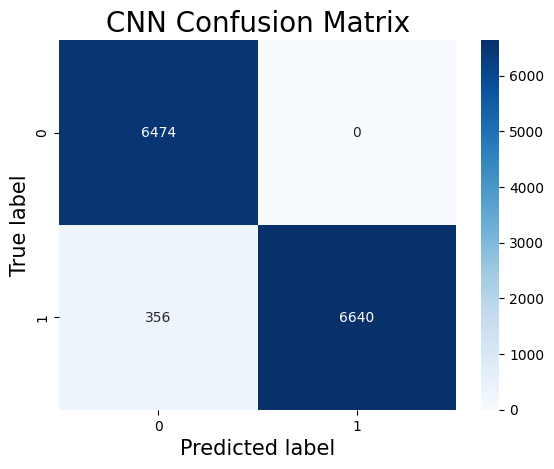

In [ ]:
from sklearn.metrics import accuracy_score , ConfusionMatrixDisplay , classification_report , roc_curve

import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_pred = model.predict(X_test)
y_pred = model.predict(X_test).astype(float)
cm = confusion_matrix(Y_test,  np.round(abs(y_pred)))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)

plt.title('CNN Confusion Matrix', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted label', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True label', fontsize = 15) # y-axis label with fontsize 15

plt.show()